In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

In [15]:
df = pd.read_excel("Case Study 1 Data (1).xlsx")
df.head()

,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0
2,SI_000003,CityC,2094.0,2.0,2.0,1950.0,Good,Single Family,2020-11-30,385000.0
3,SI_000004,CityB,1930.0,2.0,3.0,1905.0,Good,Single Family,2021-12-09,651000.0
4,SI_000005,CityB,1895.0,5.0,2.0,1936.0,New,Single Family,2024-10-30,1878000.0


## EDA

In [16]:
df.isnull().sum()

Property ID        0
Location           0
Size            2471
Bedrooms        8403
Bathrooms       6673
Year Built     12605
Condition      10628
Type               0
Date Sold          0
Price           5437
dtype: int64

In [17]:
df.shape

(247172, 10)

In [18]:
# Drop all rows with any missing values
df.dropna(inplace=True)

# Optional: Reset index after dropping
df.reset_index(drop=True, inplace=True)

# Check to confirm
print("Remaining rows:", len(df))
print("Any missing values left?\n", df.isnull().sum())

Remaining rows: 234567
Any missing values left?
 Property ID    0
Location       0
Size           0
Bedrooms       0
Bathrooms      0
Year Built     0
Condition      0
Type           0
Date Sold      0
Price          0
dtype: int64


In [19]:
df.dtypes

Property ID            object
Location               object
Size                  float64
Bedrooms              float64
Bathrooms             float64
Year Built            float64
Condition              object
Type                   object
Date Sold      datetime64[ns]
Price                 float64
dtype: object

In [20]:
df.describe()

,Size,Bedrooms,Bathrooms,Year Built,Date Sold,Price
count,234567.000000,234567.000000,234567.000000,234567.000000,234567,2.345670e+05
mean,2402.601530,3.000554,2.003440,1961.429191,2022-07-02 08:14:30.751639808,4.660205e+05
min,800.000000,1.000000,1.000000,1900.000000,2020-01-01 00:00:00,2.600000e+04
25%,1603.000000,2.000000,1.000000,1931.000000,2021-04-02 00:00:00,3.000000e+05
50%,2404.000000,3.000000,2.000000,1961.000000,2022-07-03 00:00:00,4.170000e+05
75%,3202.000000,4.000000,3.000000,1992.000000,2023-10-02 00:00:00,5.770000e+05
max,3999.000000,5.000000,3.000000,2023.000000,2024-12-31 00:00:00,2.223000e+06
std,923.410666,1.415133,0.816598,35.752638,NaN,2.314472e+05


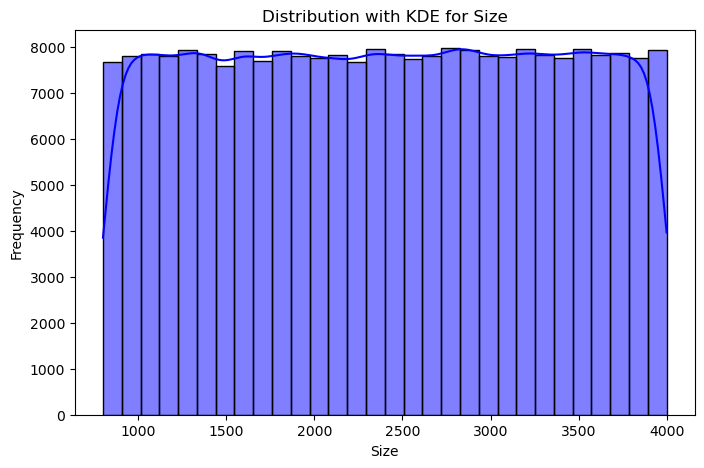

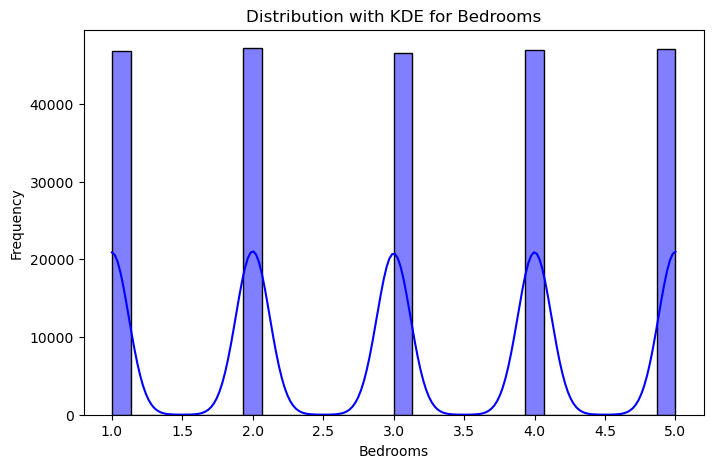

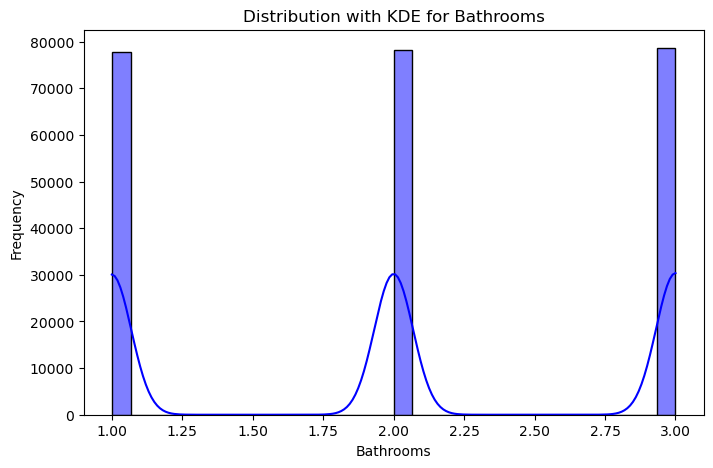

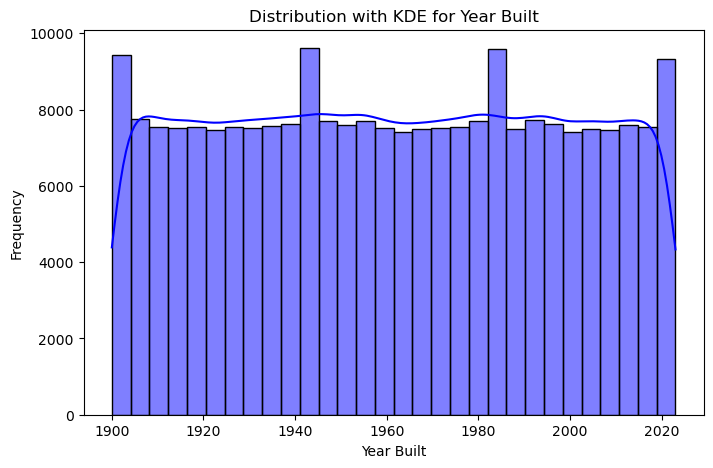

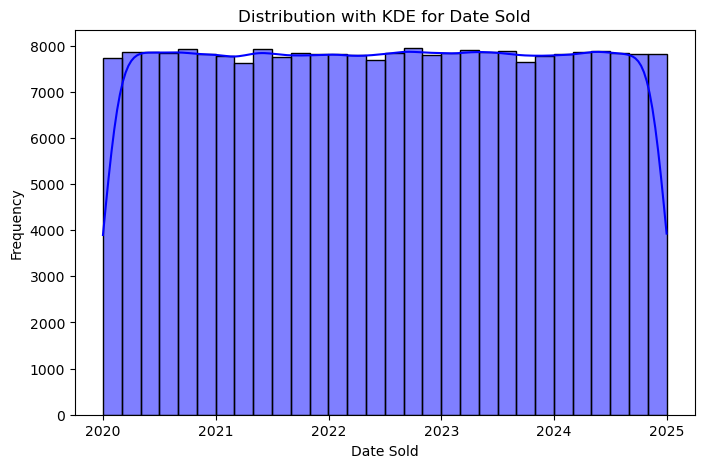

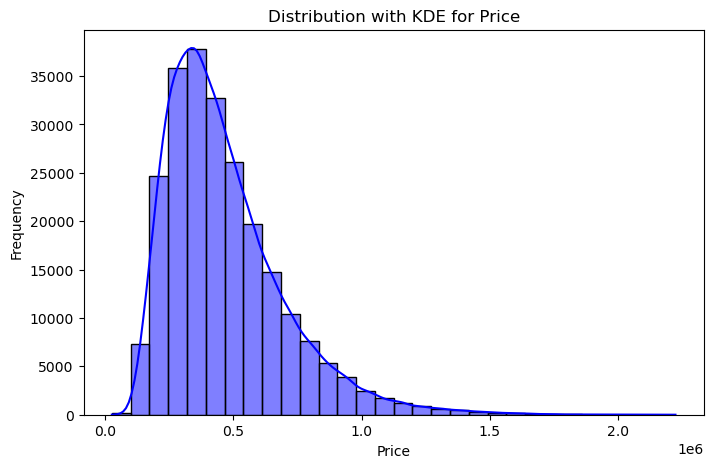

In [21]:
numerical_col = [column for column in df.columns if df[column].dtype != 'object'] # seperated numerical columns

for col in numerical_col:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution with KDE for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [22]:
df.columns

Index(['Property ID', 'Location', 'Size', 'Bedrooms', 'Bathrooms',
       'Year Built', 'Condition', 'Type', 'Date Sold', 'Price'],
      dtype='object')

In [23]:
df.drop('Property ID', axis=1, inplace=True)

In [24]:
df["Date Sold"] = pd.to_datetime(df["Date Sold"])
df["Year Sold"] = df["Date Sold"].dt.year
df["Month Sold"] = df["Date Sold"].dt.month
df.drop(columns=["Date Sold"], inplace=True)


## ------------ Using Ordinal Encoder to Encode Ordinal Values -------------

In [26]:
ordinal_columns = ['Location', 'Condition', 'Type']

categories = [['CityA', 'CityB', 'CityC', 'CityD'],
              ['Fair', 'Good', 'New', 'Poor'],
              ['Condominium', 'Single Family', 'Townhouse']]

encoder = OrdinalEncoder(categories=categories)
df[ordinal_columns] = encoder.fit_transform(df[ordinal_columns])

## ------------ Separating Categorical and Numerical columns --------------

In [27]:
categorical_col = [column for column in df.columns if df[column].dtype == 'object']
numerical_col = [column for column in df.columns if df[column].dtype != 'object']

In [28]:
len(categorical_col), len(numerical_col)

(0, 10)

## ------------ Lower cap strings for better accessibility --------------

In [29]:
for column in categorical_col:
    df[column] = df[column].str.lower()

## ------------ Checking Correlation ------------

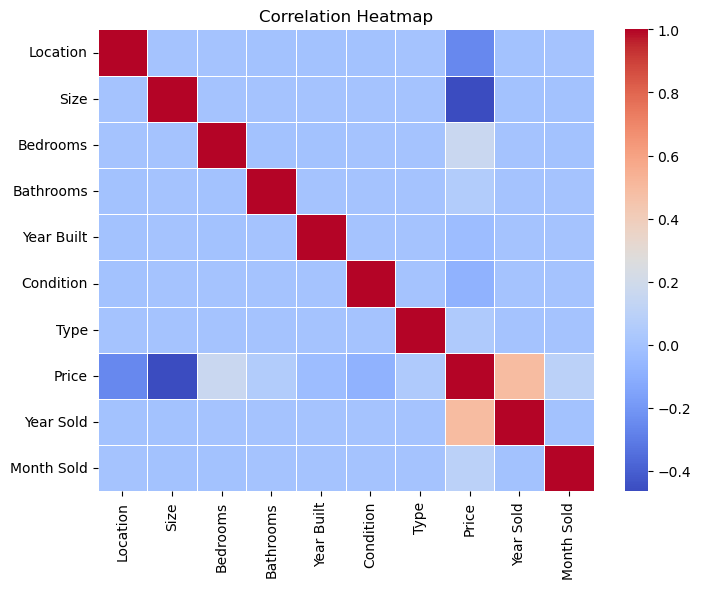

In [30]:
correlation_matrix = df[numerical_col].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## ------------ Splitting Dataset and Picking Out Smaller Sample ------------
--------------- Reducing Number of rows to speed up training due to low compute power -----------

In [31]:
# Randomly sample 40% of the data
df_sampled = df.sample(frac=0.4, random_state=1)

In [32]:
df_sampled

,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Price,Year Sold,Month Sold
208616,2.0,1773.0,5.0,2.0,1983.0,0.0,2.0,501000.0,2022,8
186966,0.0,2642.0,5.0,3.0,2014.0,1.0,2.0,592000.0,2022,12
108374,2.0,914.0,5.0,3.0,1905.0,1.0,0.0,596000.0,2021,12
21111,0.0,2112.0,5.0,1.0,1901.0,1.0,1.0,577000.0,2020,6
153370,0.0,3529.0,2.0,2.0,1956.0,0.0,2.0,328000.0,2024,8
...,...,...,...,...,...,...,...,...,...,...
128622,3.0,1584.0,2.0,2.0,1929.0,0.0,0.0,424000.0,2023,10
154264,2.0,3822.0,1.0,1.0,1979.0,1.0,2.0,253000.0,2022,7
59521,2.0,3585.0,1.0,3.0,1981.0,1.0,1.0,224000.0,2020,9
229647,3.0,3802.0,3.0,3.0,1987.0,3.0,2.0,181000.0,2023,4


In [33]:
X = df_sampled.drop('Price', axis=1)  
y = df_sampled['Price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [34]:
len(X_test), len(X_train)

(18766, 75061)

## ------------ Encoding Categorical Variables ------------
DictVectorizer automatically handles categorical columns

In [35]:
train_dicts = X_train.to_dict(orient='records') # using resampled data as our train feature
test_dicts = X_test.to_dict(orient='records')

In [36]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)

### Training The Model
- Training Using Different Models and Evaluating Their Results
- Helper function and list to evaluate models and store scores

In [37]:
model_results = []

def evaluate_model(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    return mae, mse, rmse, r2

## Linear Regression

In [38]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [39]:
y_pred = model.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2

(113302.70352191082,
 23212829544.485695,
 152357.57133954877,
 0.5739966935392551)

## Decision Tree
- Tuning Parameter

In [40]:
scores = []

for i in range(1, 12):
    for min_sample_leaf_values in [1, 3, 4, 5, 6, 8, 10, 15]:
        dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_sample_leaf_values, random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)

        scores.append((i, min_sample_leaf_values, mae, mse, rmse, r2))

In [41]:
df_scores = pd.DataFrame(scores, columns=['depth', 'leaf', 'mae', 'mse', 'rmse', 'r2'])

In [42]:
df_scores

,depth,leaf,mae,mse,rmse,r2
0,1,1,156426.394766,4.374525e+10,209153.661310,0.197184
1,1,3,156426.394766,4.374525e+10,209153.661310,0.197184
2,1,4,156426.394766,4.374525e+10,209153.661310,0.197184
3,1,5,156426.394766,4.374525e+10,209153.661310,0.197184
4,1,6,156426.394766,4.374525e+10,209153.661310,0.197184
...,...,...,...,...,...,...
83,11,5,39707.113810,2.815598e+09,53062.210730,0.948328
84,11,6,39681.032096,2.814199e+09,53049.019826,0.948354
85,11,8,39728.608647,2.817616e+09,53081.217470,0.948291
86,11,10,39803.787921,2.832450e+09,53220.770975,0.948019


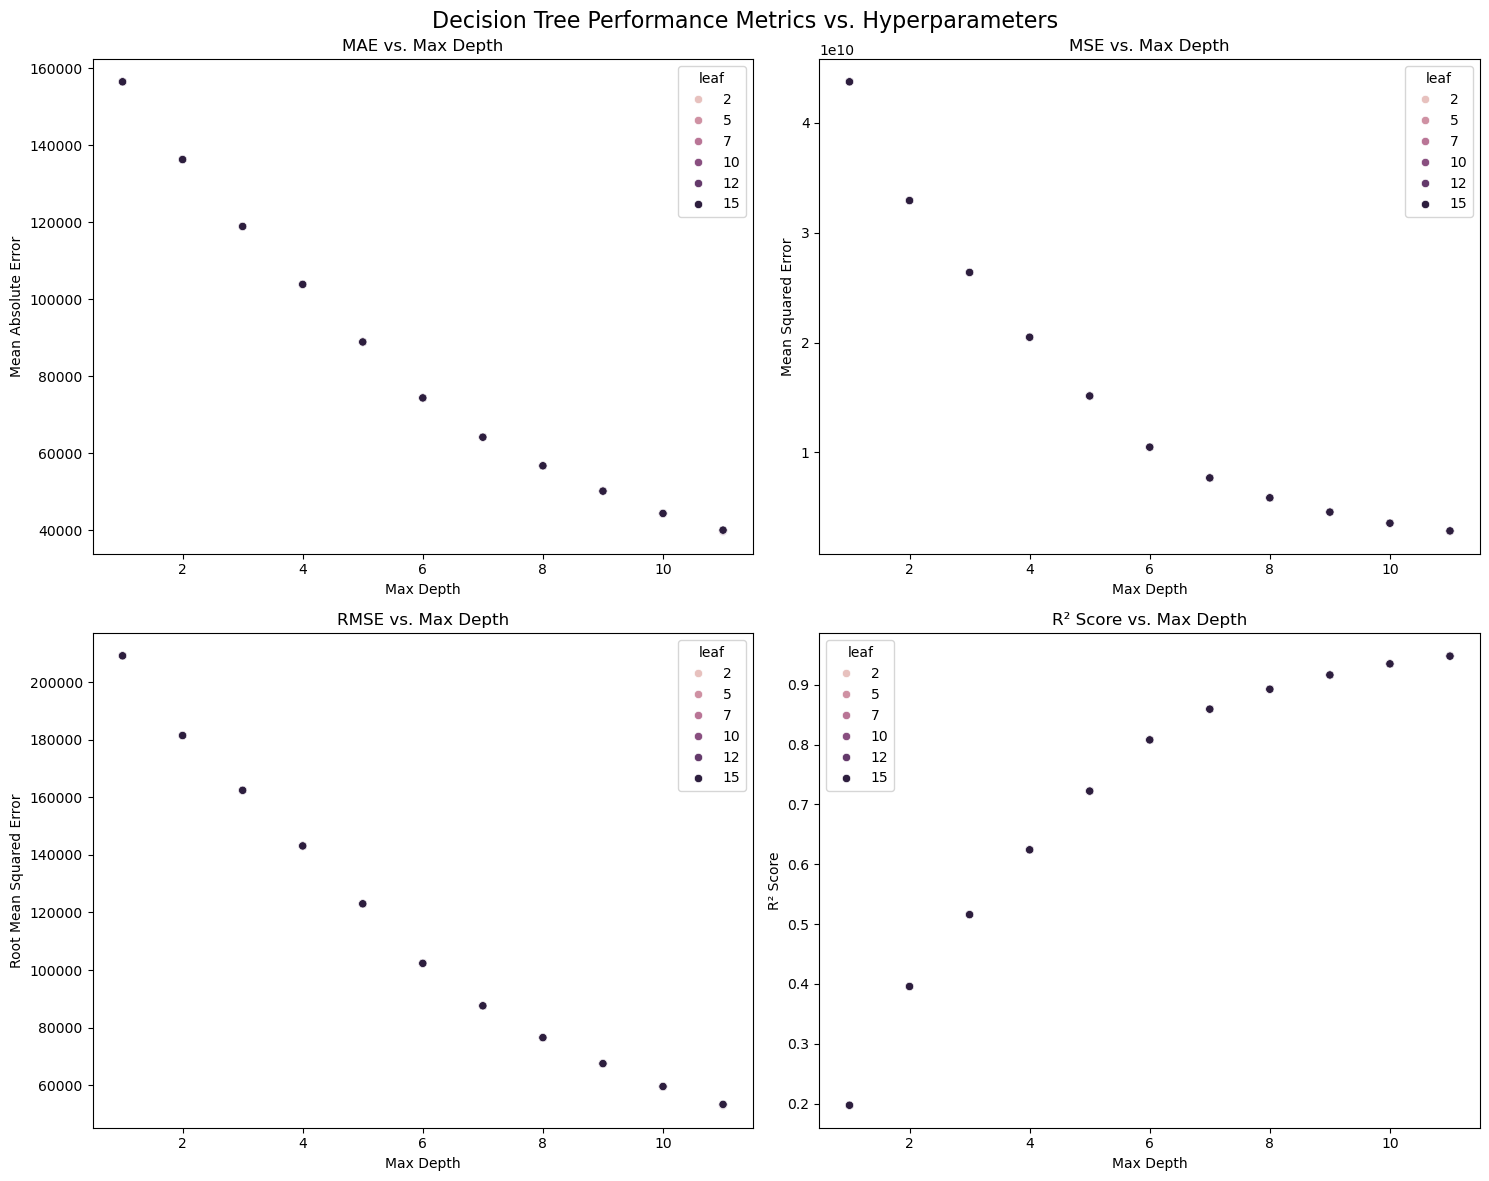


Best Parameters for different metrics:

Best parameters for minimum MAE:
depth    1.100000e+01
leaf     6.000000e+00
mae      3.968103e+04
mse      2.814199e+09
rmse     5.304902e+04
r2       9.483537e-01
Name: 84, dtype: float64

Best parameters for minimum MSE:
depth    1.100000e+01
leaf     6.000000e+00
mae      3.968103e+04
mse      2.814199e+09
rmse     5.304902e+04
r2       9.483537e-01
Name: 84, dtype: float64

Best parameters for minimum RMSE:
depth    1.100000e+01
leaf     6.000000e+00
mae      3.968103e+04
mse      2.814199e+09
rmse     5.304902e+04
r2       9.483537e-01
Name: 84, dtype: float64

Best parameters for maximum R2:
depth    1.100000e+01
leaf     6.000000e+00
mae      3.968103e+04
mse      2.814199e+09
rmse     5.304902e+04
r2       9.483537e-01
Name: 84, dtype: float64


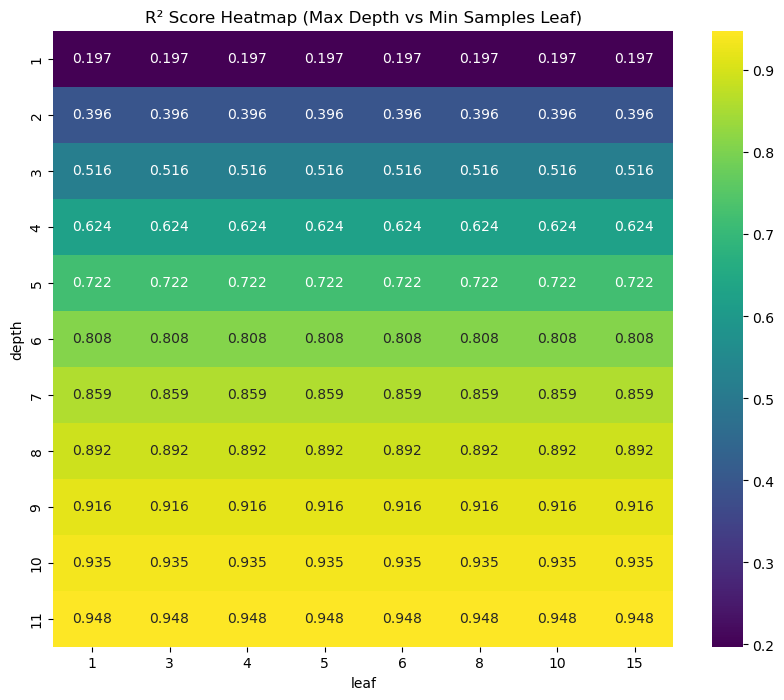

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Tree Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='depth', y='mae', hue='leaf', ax=axes[0,0])
axes[0,0].set_title('MAE vs. Max Depth')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='depth', y='mse', hue='leaf', ax=axes[0,1])
axes[0,1].set_title('MSE vs. Max Depth')
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='rmse', hue='leaf', ax=axes[1,0])
axes[1,0].set_title('RMSE vs. Max Depth')
axes[1,0].set_xlabel('Max Depth')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='r2', hue='leaf', ax=axes[1,1])
axes[1,1].set_title('R² Score vs. Max Depth')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

# Find the best parameters based on different metrics
print("\nBest Parameters for different metrics:")
print("\nBest parameters for minimum MAE:")
print(df_scores.loc[df_scores['mae'].idxmin()])

print("\nBest parameters for minimum MSE:")
print(df_scores.loc[df_scores['mse'].idxmin()])

print("\nBest parameters for minimum RMSE:")
print(df_scores.loc[df_scores['rmse'].idxmin()])

print("\nBest parameters for maximum R2:")
print(df_scores.loc[df_scores['r2'].idxmax()])

# Create a heatmap for R2 scores
plt.figure(figsize=(10, 8))
pivot_table = df_scores.pivot(index='depth', columns='leaf', values='r2')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('R² Score Heatmap (Max Depth vs Min Samples Leaf)')
plt.show()

##### Choosing Leaf = 6.000000e+00 and depth = 1.100000e+01 since the scores are improving as depth increases

In [47]:
from sklearn.tree import DecisionTreeRegressor

# Corrected parameters: use int, not float
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=6, random_state=1)

# Train the model
dt.fit(X_train, y_train)

# Predict on test set
y_pred = dt.predict(X_test)

# Evaluate the model
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2


(44278.777801474236, 3541681462.3942738, 59512.02788003677, 0.9350028392480442)

In [48]:
model_results.append({
    "Model": "Decision Tree",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

## Random Forest

In [49]:
rf = RandomForestRegressor(random_state=1, n_jobs=-1, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

(22772.75560410672, 897840276.3666856, 29963.98298568943, 0.9835227788291455)

##### ------- Tuning N_estimator -----------

In [50]:
scores = []

for n in range(10, 301, 40): # going to 200 with 40 steps
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1, max_features='sqrt')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
    mae, mse, rmse, r2 
    scores.append((n, mae, mse, rmse, r2))

In [51]:
df_scores = pd.DataFrame(scores, columns=['n_estimator', 'mae', 'mse', 'rmse', 'r2'])

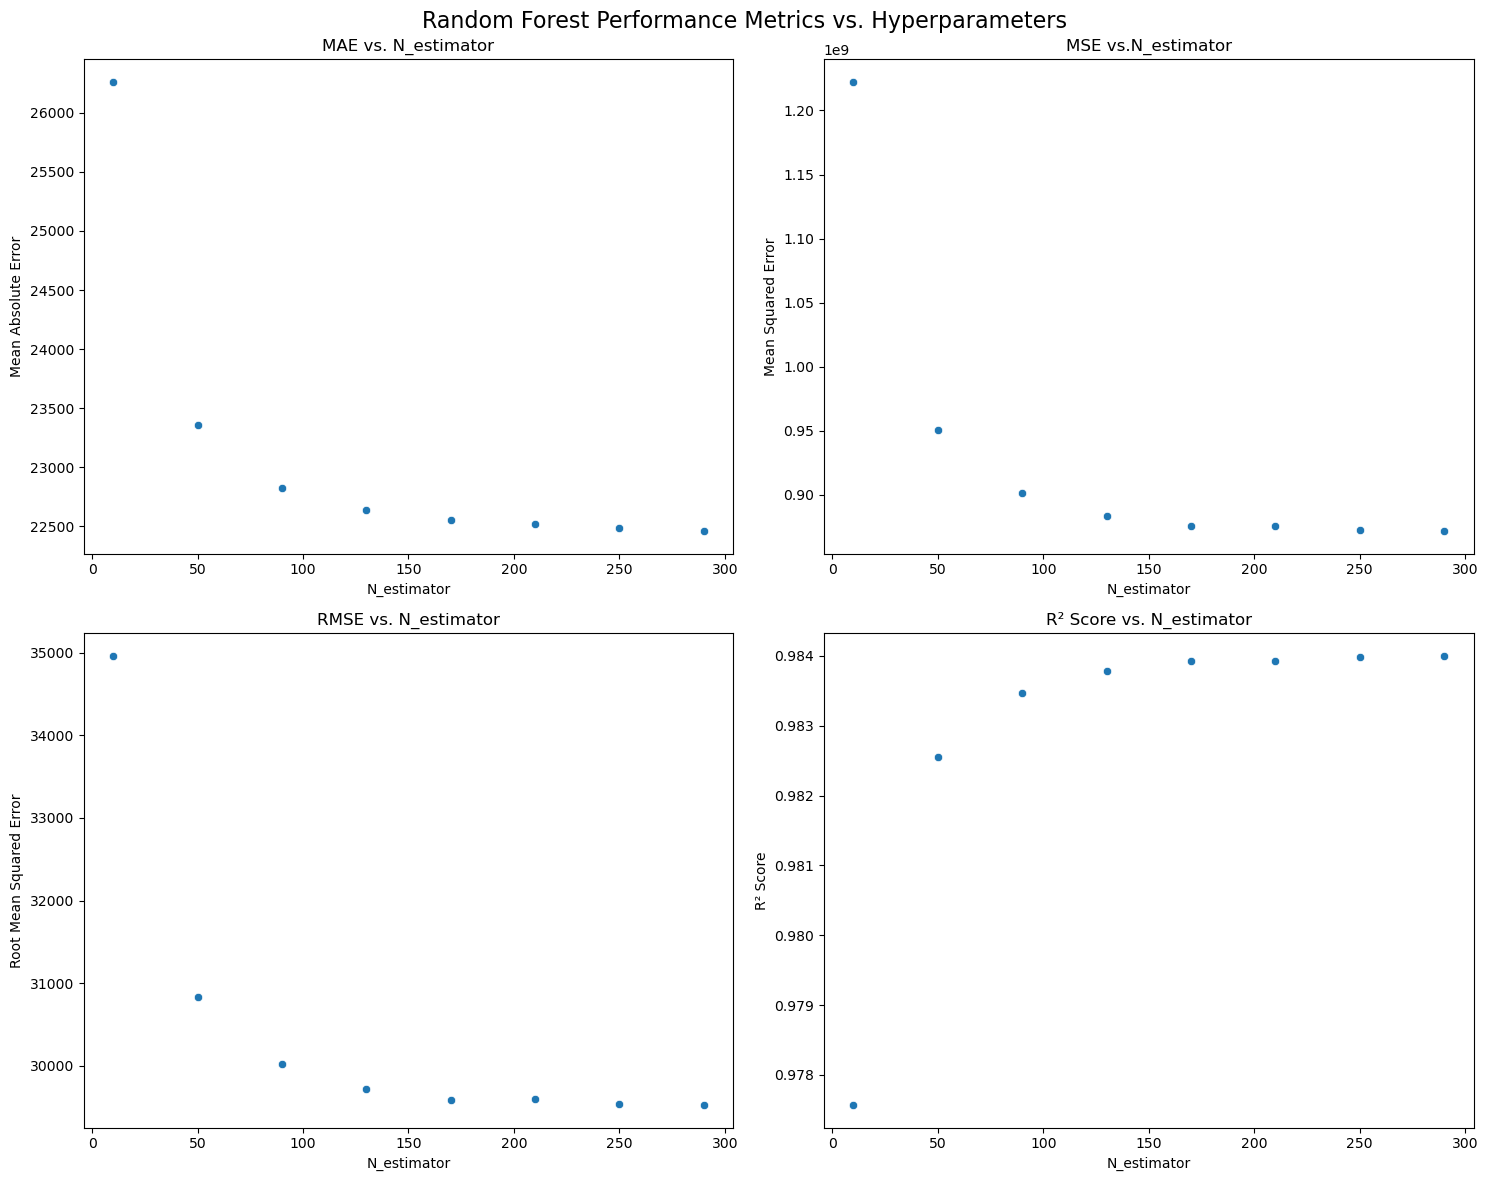

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='n_estimator', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. N_estimator')
axes[0,0].set_xlabel('N_estimator')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.N_estimator')
axes[0,1].set_xlabel('N_estimator')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. N_estimator')
axes[1,0].set_xlabel('N_estimator')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. N_estimator')
axes[1,1].set_xlabel('N_estimator')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

#### 100 n_estimators

--------- Tuning depths ----------

In [53]:
scores = []

for d in [1, 3, 5, 10, 20, 25, 35, 50]: # tuning depths
    rf = RandomForestRegressor(max_depth=d ,n_estimators=100, random_state=1, n_jobs=-1, 
                               max_features='sqrt', verbose=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
    mae, mse, rmse, r2 
    scores.append((d, mae, mse, rmse, r2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parall

In [54]:
df_scores = pd.DataFrame(scores, columns=['depth', 'mae', 'mse', 'rmse', 'r2'])

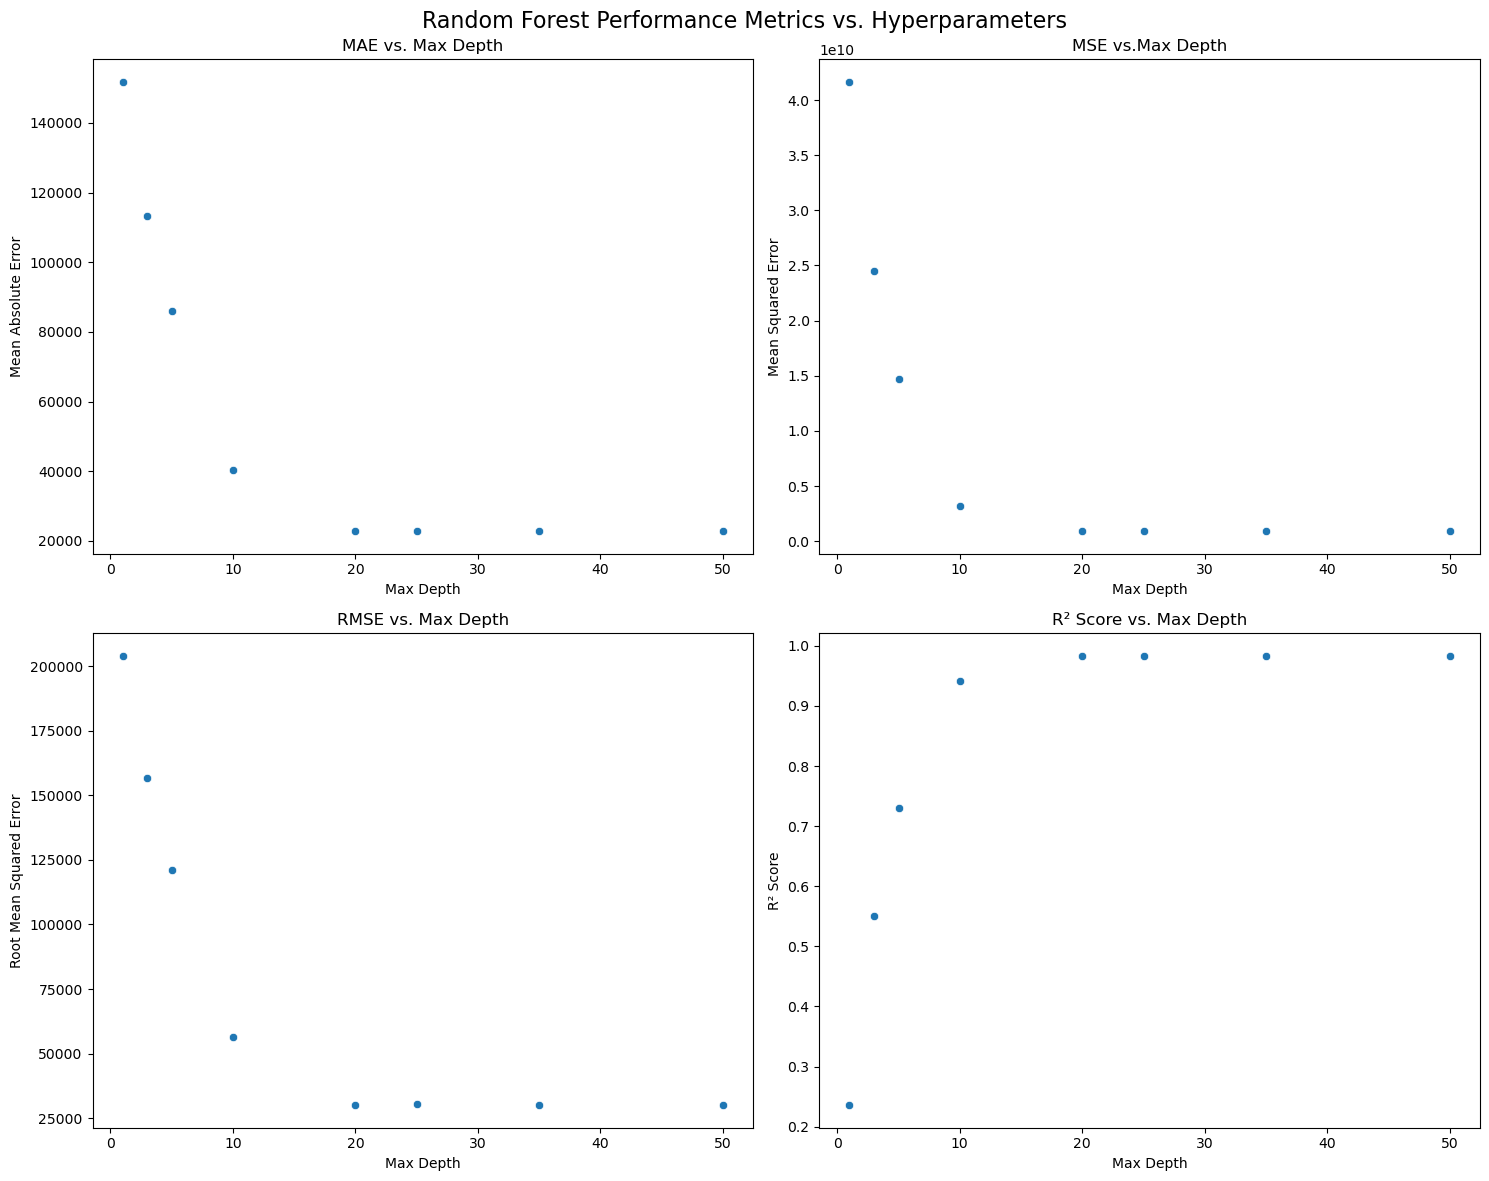

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='depth', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. Max Depth')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='depth', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.Max Depth')
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. Max Depth')
axes[1,0].set_xlabel('Max Depth')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. Max Depth')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

#### ------------ Taking max_depth 50 and tuning min_sample_leaf ---------

In [56]:
scores = []

for s in [1, 3, 5, 10, 20, 35]: # tuning depths
    rf = RandomForestRegressor(max_depth=50 ,n_estimators=100, min_samples_leaf=s, random_state=1, n_jobs=-1, 
                               max_features='sqrt', verbose=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
    mae, mse, rmse, r2 
    scores.append((s, mae, mse, rmse, r2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parall

In [57]:
df_scores = pd.DataFrame(scores, columns=['leaf', 'mae', 'mse', 'rmse', 'r2'])

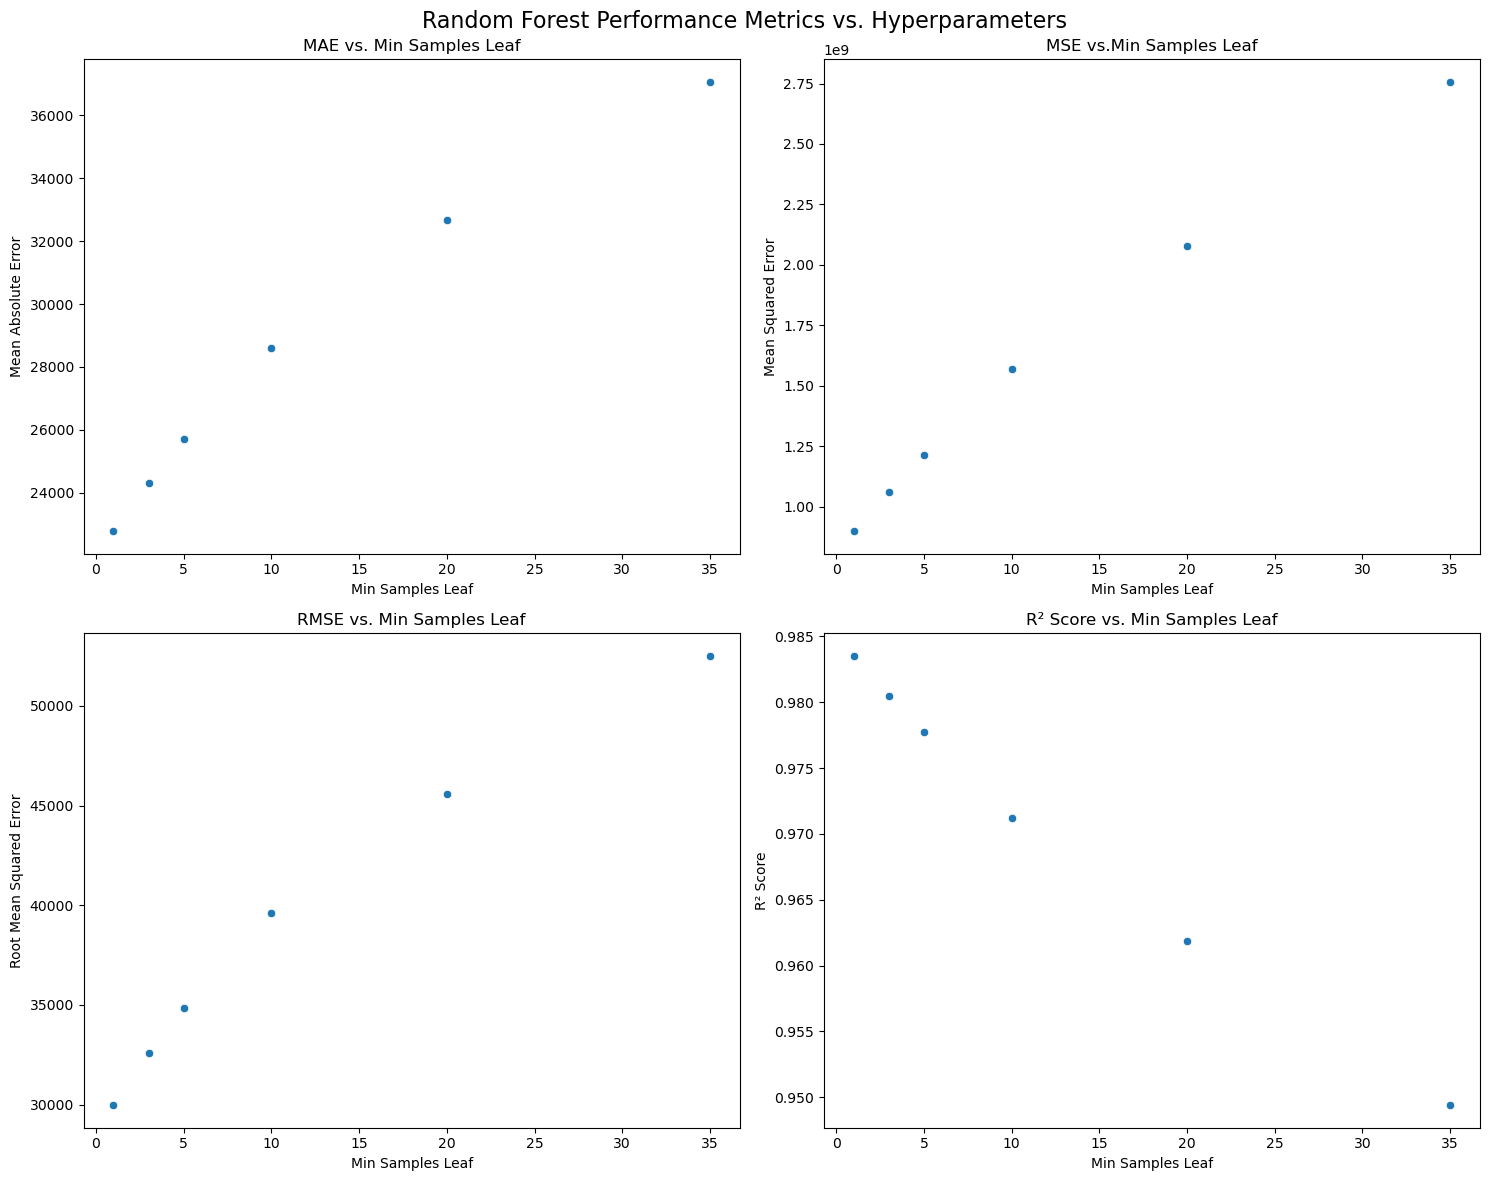

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='leaf', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. Min Samples Leaf')
axes[0,0].set_xlabel('Min Samples Leaf')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='leaf', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.Min Samples Leaf')
axes[0,1].set_xlabel('Min Samples Leaf')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='leaf', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. Min Samples Leaf')
axes[1,0].set_xlabel('Min Samples Leaf')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='leaf', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. Min Samples Leaf')
axes[1,1].set_xlabel('Min Samples Leaf')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()


### --------- Taking Min_sample_leaf = 1 ---------

In [59]:
rf = RandomForestRegressor(max_depth=50 ,n_estimators=100, min_samples_leaf=1, random_state=1, n_jobs=-1, max_features='sqrt', verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


(22772.75560410672, 897840276.3666856, 29963.98298568943, 0.9835227788291455)

In [60]:
model_results.append({
    "Model": "Random Forest",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})


## XGBoost

In [61]:
features_name = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_name)
dtest = xgb.DMatrix(X_test, feature_names=features_name)

In [62]:
xgb = XGBRegressor(random_state=1, objective='reg:squarederror')

In [63]:
param_grid = {
    'tree_method': ['hist'],  # Use 'hist' tree_method
    'device': ['cuda'],  # Use GPU via CUDA
    'n_estimators': [100],  # Number of boosting rounds
    'max_depth': [3, 10, 20],         # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
}

In [64]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative MSE (higher is better)
    cv=3,                             # 3-fold cross-validation
    verbose=1,                        # Show progress
    n_jobs=-1                         # Use all CPUs
)

In [65]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\jitendra\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\jitendra\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'device': ['cuda'], 'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 10, 20], 'n_estimators': [100],
                         'tree_method': ['hist']},
             scoring='neg_mean_squared_error', verbose=1)

In [66]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)  # Convert back from negative MSE

Best Parameters: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'hist'}
Best Score: 589469629.3194082


In [67]:
xgb = XGBRegressor(tree_method='hist',
                   device='cuda',
                   n_estimators=100,
                   max_depth=10,
                   learning_rate=0.1,
                   random_state=1, objective='reg:squarederror')

xgb.fit(X_train, y_train)

C:\Users\jitendra\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\jitendra\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [68]:
y_pred = xgb.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

(18425.803491437306, 543346026.9403186, 23309.78393165236, 0.9900284795705196)

In [69]:
model_results.append({
    "Model": "XGBoost",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

In [76]:
model_results = [
    {'Model': 'Decision Tree',
     'MAE': 44278.777801474236,
     'MSE': 3541681462.3942738,
     'RMSE': 59512.02788003677,
     'R2': 0.9350028392480442},
    
    {'Model': 'Random Forest',
     'MAE': 22772.75560410672,
     'MSE': 897840276.3666856,
     'RMSE': 29963.98298568943,
     'R2': 0.9835227788291455},
    
    {'Model': 'XGBoost',
     'MAE': 18425.803491437306,
     'MSE': 543346026.9403186,
     'RMSE': 23309.78393165236,
     'R2': 0.9900284795705196},
    
    {'Model': 'Linear Regression',
     'MAE': 113302.70352191082,
     'MSE': 23212829544.485695,
     'RMSE': 152357.57133954877,
     'R2': 0.5739966935392551}
]


In [77]:
model_results

[{'Model': 'Decision Tree',
  'MAE': 44278.777801474236,
  'MSE': 3541681462.3942738,
  'RMSE': 59512.02788003677,
  'R2': 0.9350028392480442},
 {'Model': 'Random Forest',
  'MAE': 22772.75560410672,
  'MSE': 897840276.3666856,
  'RMSE': 29963.98298568943,
  'R2': 0.9835227788291455},
 {'Model': 'XGBoost',
  'MAE': 18425.803491437306,
  'MSE': 543346026.9403186,
  'RMSE': 23309.78393165236,
  'R2': 0.9900284795705196},
 {'Model': 'Linear Regression',
  'MAE': 113302.70352191082,
  'MSE': 23212829544.485695,
  'RMSE': 152357.57133954877,
  'R2': 0.5739966935392551}]

### Evaluating Best Model

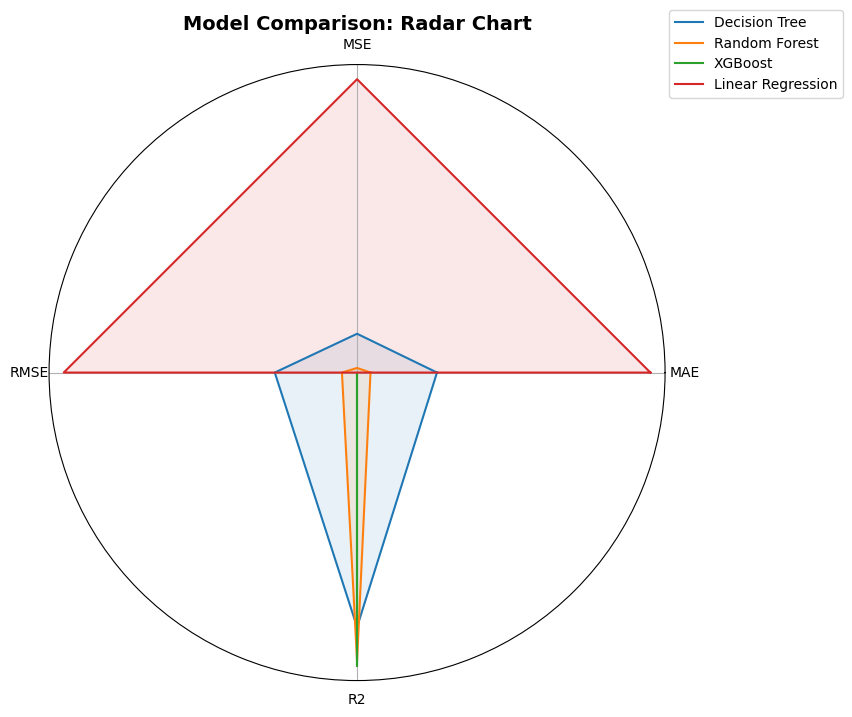

In [78]:
df = pd.DataFrame(model_results)

# Normalize metrics for better visualization (0-1 scale)
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
normalized_df = df.copy()
for metric in metrics:
    normalized_df[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in normalized_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Model Comparison: Radar Chart", fontsize=14, weight='bold')

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.savefig('data science 1.png', dpi=300)  # Save to the output directory

plt.show()

C:\Users\jitendra\AppData\Local\Temp\ipykernel_5440\1799764528.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
C:\Users\jitendra\AppData\Local\Temp\ipykernel_5440\1799764528.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\jitendra\AppData\Local\Temp\ipykernel_5440\1799764528.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
C:\Users\jitendra\AppData\Local\Temp\ipykernel_5440\1799764528.py:14: UserWarning: set_ticklabels() should

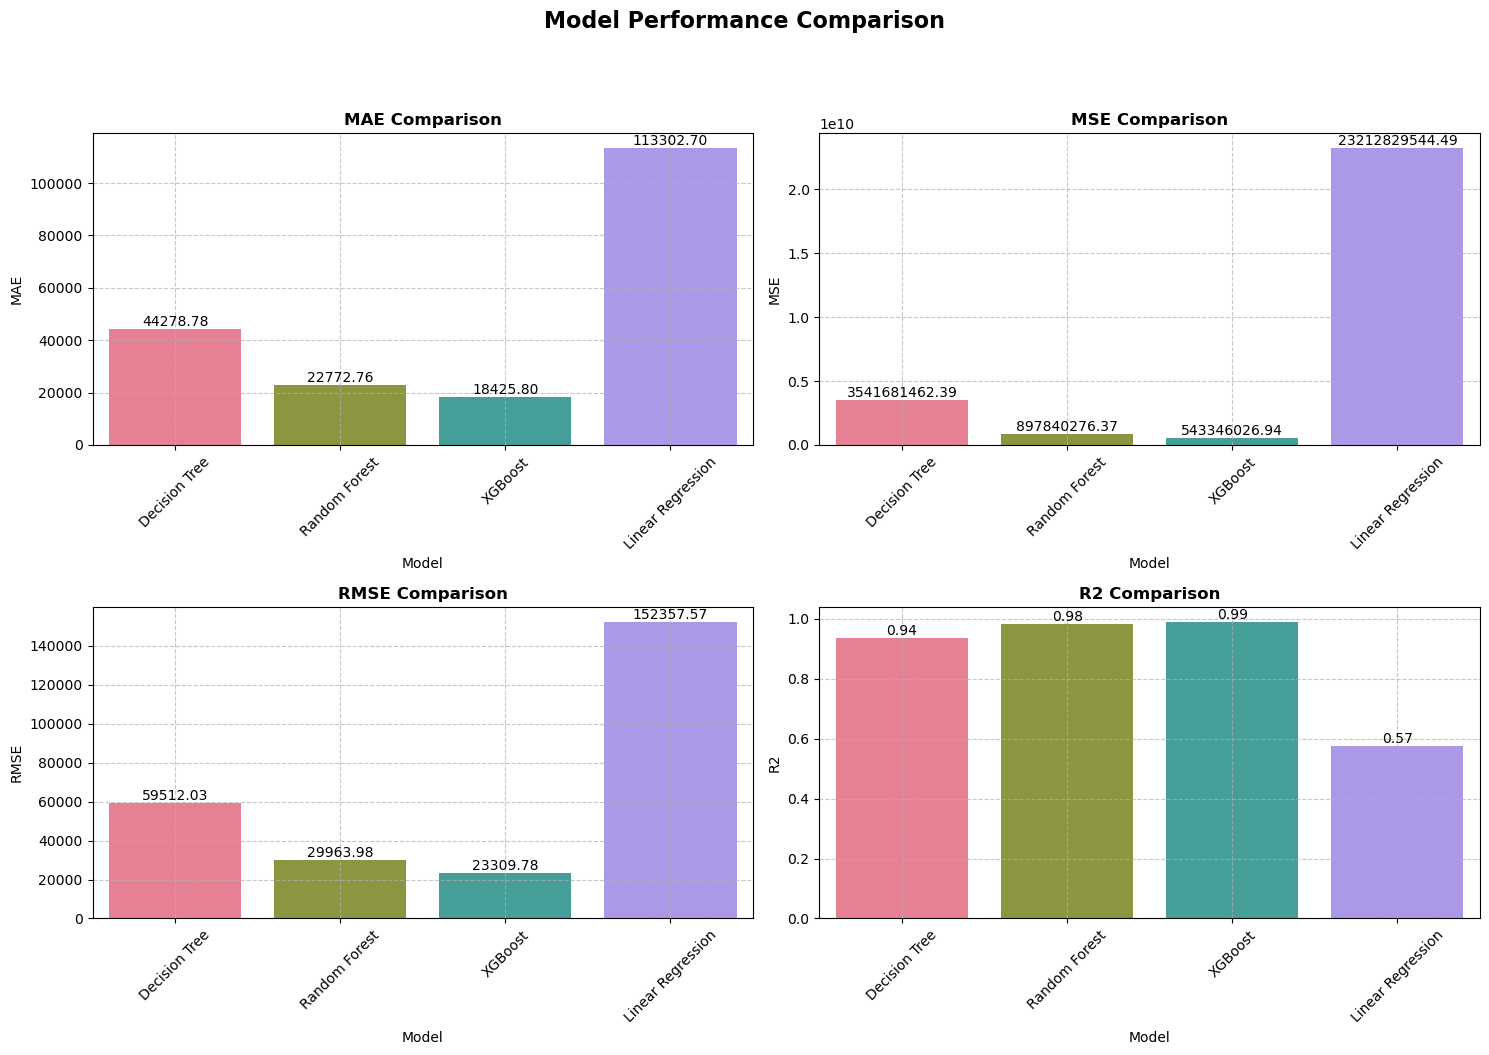

In [79]:
df = pd.DataFrame(model_results)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.05)

axes = axes.flatten()

metrics = ['MAE', 'MSE', 'RMSE', 'R2']
colors = sns.color_palette("husl", 4)

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for j, v in enumerate(df[metric]):
        ax.text(j, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('data science 101.png', dpi=300)  # Save to the output directory

plt.show()

## XGBoost clearly performed well here. Do note that for RMSE, MSE, and MAE metrics, the lower the value the better, For R2, higher values indicate better benchmark.